In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel

import time
import math
import inspect
import numpy as np

from dataclasses import dataclass

device = "cuda" if torch.cuda.is_available() else "cpu"
device

c:\Users\yashs\miniconda3\envs\learn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

## GPT-2 Architecture

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")  # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [3]:
import os

CWD = os.getcwd()
PWD = CWD + "/projects/gpt2/" if not CWD.endswith("gpt2") else ""
PWD

''

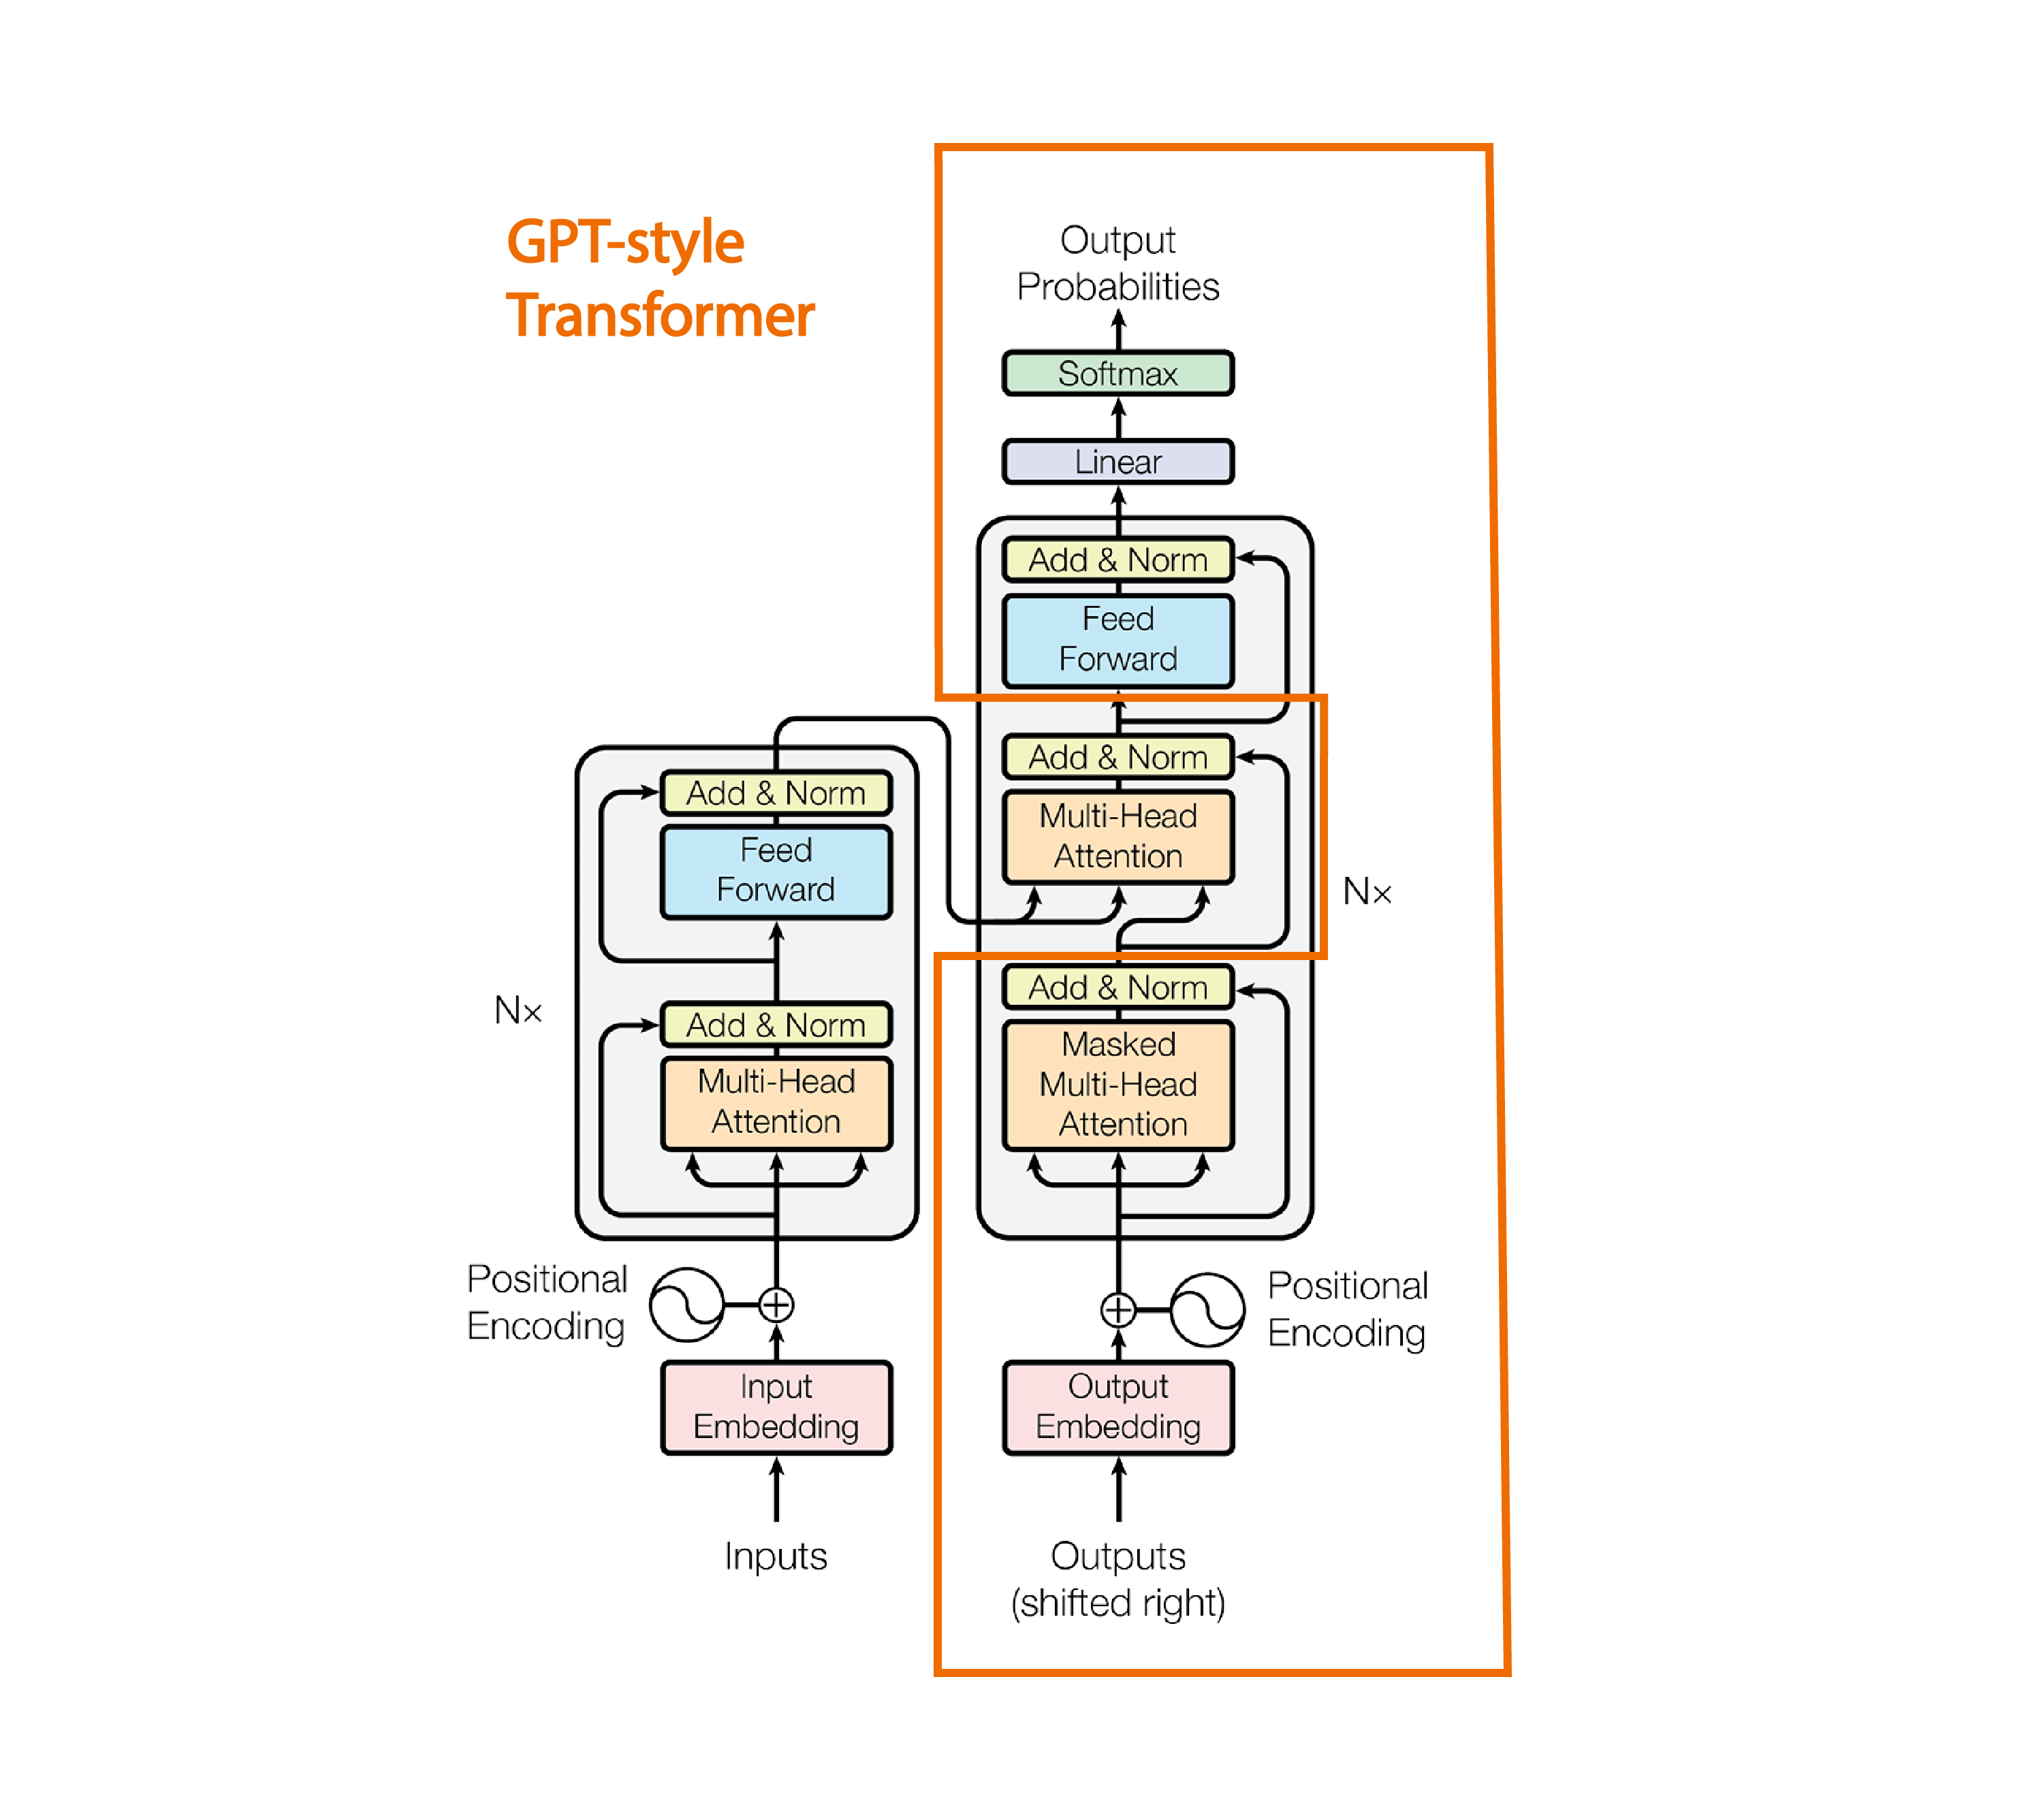

In [4]:
from IPython.display import Image

Image(PWD + "images/gpt2-arch.png", width=700, height=700)

In [5]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CasualSelfAttention(config)     # Reduce Operation
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)                      # Mapping Operation

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


## Flash Attention

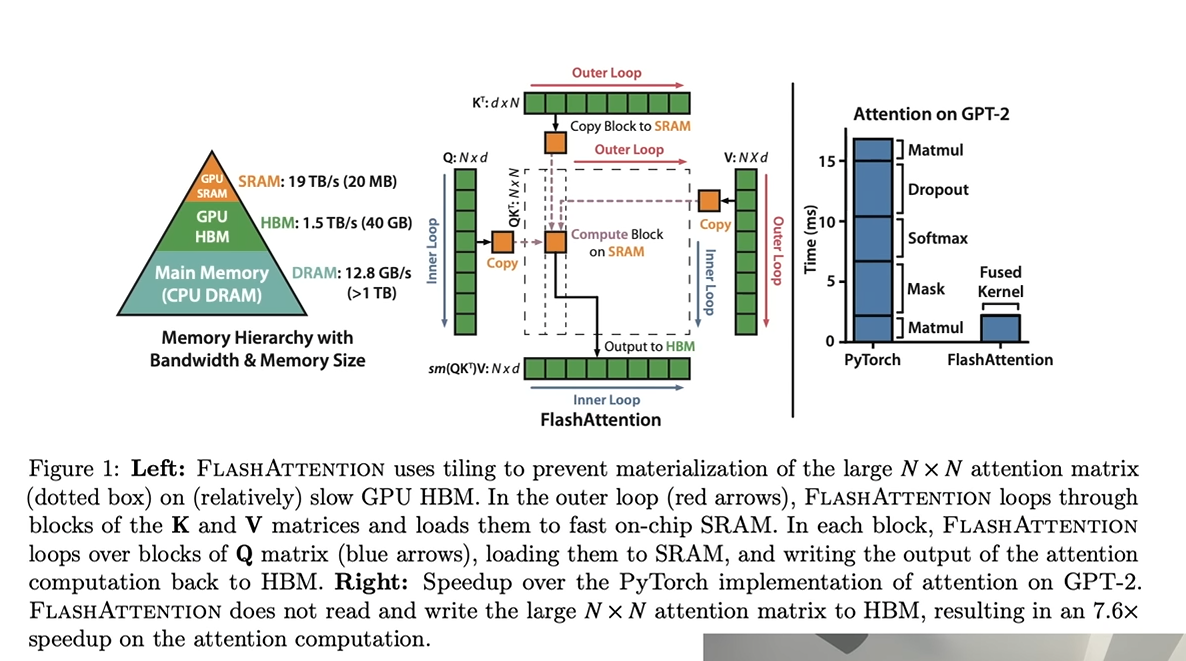

In [6]:
# 7.6x speedup in comparison to vanilla-attention

from IPython.display import Image

Image(PWD + "images/flash-attn.png", width=1000)

In [7]:
class CasualSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        
        # query, key and value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)

        # output projection for all heads in a batch
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        # not actually 'bias', but a mask instead
        self.register_buffer('bias', torch.tril(torch.ones(config.block_size, config.block_size))
                            .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        # batch size, sequence length, embedding dimension
        B, T, C = x.size()

        # calculate query, key and value projections for all heads in a batch
        qkv = self.c_attn(x)
        
        # split into query, key and value projections
        q, k, v = qkv.split(self.n_embd, dim=2)

        # nh = "number of heads" and hs = "head size"
        # (B, T, C) -> (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # NOTE: Generic Attention Implementation
        """
        attn = q @ k.transpose(-2, -1) * (1.0 / math.sqrt(k.size(-1)))
        attn = attn.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        attn = F.softmax(attn, dim=-1)

        # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = attn @ v
        """

        # Flash Attention Implementation
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)

        # Reassemble all heads outputs side by side
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # output projection
        y = self.c_proj(y)

        return y

In [8]:
@dataclass
class GPTConfig:
    block_size : int = 1024  # Max sequence length
    vocab_size : int = 50257 # Number of tokens: 50,000 BPE + 256 byte tokens + 1 <EOS>
    n_layer : int = 12
    n_head : int = 12
    n_embd : int = 768


class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd)
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)


        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std = (2 * self.config.n_layer) ** -0.5

            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, idx, targets=None):
        B, T = idx.size()

        assert T <= self.config.block_size

        tok_emb = self.transformer.wte(idx) # (B, T, n_embd)

        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # (T)
        pos_emb = self.transformer.wpe(pos) # (T, n_embd)

        x = tok_emb + pos_emb

        # Forward the blocks of transformer
        for block in self.transformer.h:
            x = block(x)

        # Forward the final layerNorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None if targets is None else F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))


        return logits, loss


    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel

        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]

        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model


    def configure_optimizers(self, weight_decay, learning_rate, device_type):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]

        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)

        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        

        print(f"using fused AdamW: {use_fused}")
    
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        
        return optimizer


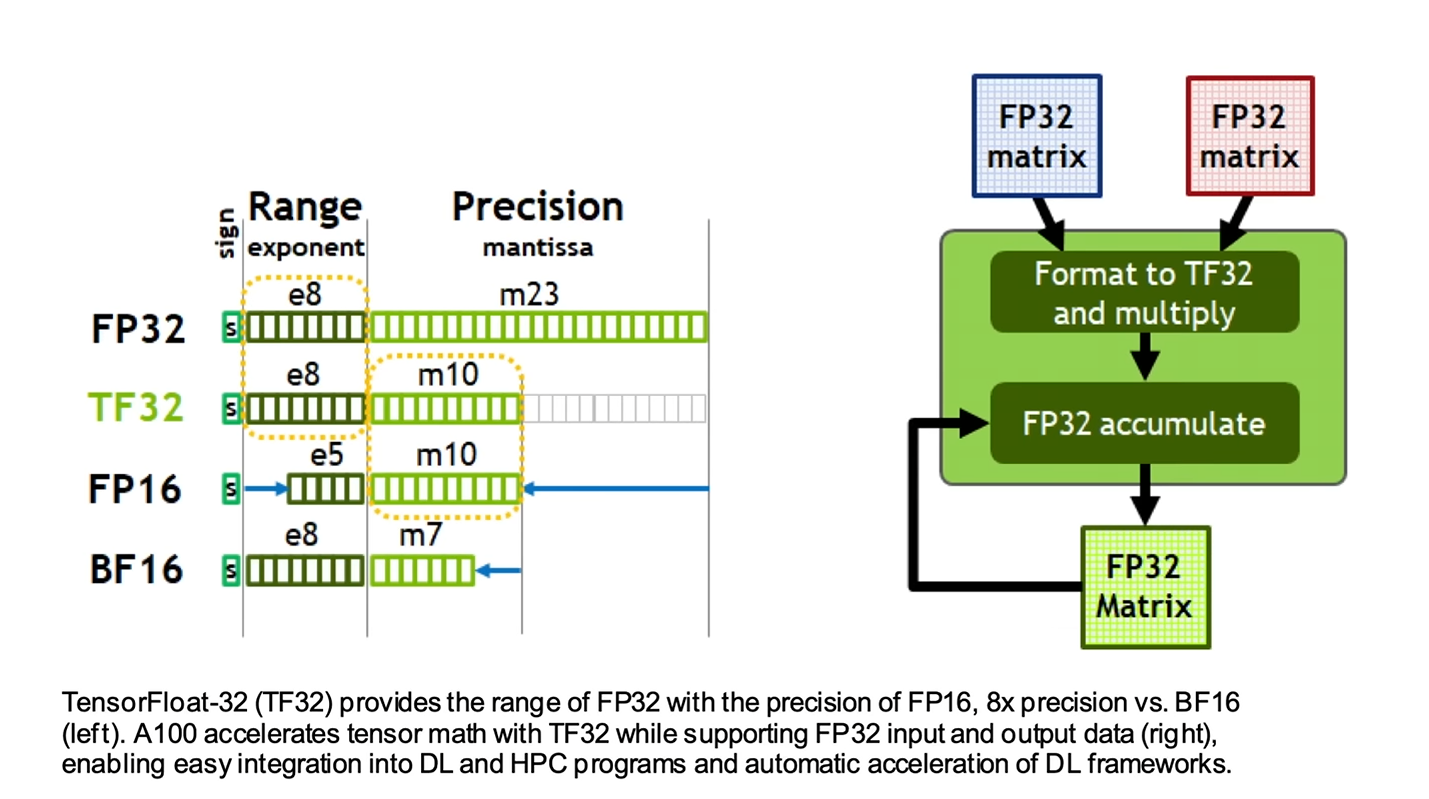

In [9]:
from IPython.display import Image

"""
Precision optimisation from the the usual FP32 can help speed up the 
training process by from 8x (TF32) to 16x (BFLOAT16).
"""
Image(PWD + "images/precision_optim.png", width=1000)

In [10]:
import tiktoken

def load_tokens(filename):
    npt = np.load(filename)
    ptt = torch.tensor(npt, dtype=torch.long)
    return ptt

class DataLoaderLite():
    def __init__(self, B, T, split):
        self.B = B
        self.T = T
        self.curr_pos = self.B * self.T
        
        assert split in {'train', 'val'}

        data_root = "edu_fineweb10B"
        shards = os.listdir(data_root)
        shards = [s for s in shards if split in s]
        shards = sorted(shards)
        shards = [os.path.join(data_root, s) for s in shards]
        self.shards = shards

        assert len(shards) > 0, f"no shards found for split {split}"
        print(f"found {len(shards)} shards for split {split}")

        self.curr_shard = 0
        self.tokens = load_tokens(self.shards[self.curr_shard])

        self.reset()


        # with open(PWD + "input.txt", "r") as f:
        #     text = f.read()
        
        # enc = tiktoken.get_encoding('gpt2')
        # self.tokens = torch.tensor(enc.encode(text))

        # print(f"loaded {len(self.tokens)} tokens")
        # print(f"1 epoch has {len(self.tokens) // (self.B * self.T)} tokens")

    def reset(self):
        self.curr_shard = 0
        self.tokens = load_tokens(self.shards[self.curr_shard])
        self.curr_pos = self.B * self.T
    
    def next_batch(self):
        buf = self.tokens[self.curr_pos : self.curr_pos + self.B * self.T + 1].to(device)
        
        x = buf[:-1].view(self.B, self.T)
        y = buf[1:].view(self.B, self.T)
        
        self.curr_pos += self.B * self.T

        if self.curr_pos + (self.B * self.T + 1) >= len(self.tokens):
            self.curr_shard += 1
            self.curr_shard %= len(self.shards)

            self.tokens = load_tokens(self.shards[self.curr_shard])
            self.curr_pos = self.B * self.T
        
        return x, y
    

total_batch_size = 524288 # 2**19, ~0.5M, in number of tokens
B = 4 # micro batch size
T = 1024 # sequence length

assert total_batch_size % (B * T) == 0, "make sure total_batch_size is divisible by B * T"

grad_accum_steps = total_batch_size // (B * T)

print(f"total desired batch size: {total_batch_size}")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")


train_loader = DataLoaderLite(B, T, "train")
val_loader = DataLoaderLite(B, T, "val")
torch.set_float32_matmul_precision('high')  # reduces accuracy but speeds up training

total desired batch size: 524288
=> calculated gradient accumulation steps: 128
found 99 shards for split train
found 1 shards for split val


In [11]:
model = GPT(GPTConfig(vocab_size=50304)) #.from_pretrained("gpt2")
# model.eval()
model.to(device);

"""
Compile the model for optimized execution.
torch.compile optimizes the model's execution by reducing **python overhead and GPU read/writes**.
This can result in significant performance improvements, especially on large models or long sequences.

NOTE: Only supports LINUX for the time being
"""
# model = torch.compile(model)

"\nCompile the model for optimized execution.\ntorch.compile optimizes the model's execution by reducing **python overhead and GPU read/writes**.\nThis can result in significant performance improvements, especially on large models or long sequences.\n\nNOTE: Only supports LINUX for the time being\n"

### Optimisation note
    """ 
    Enable mixed precision training with autocasting to reduce memory usage and improve performance.
    This allows us to take advantage of hardware-specific optimizations for low-precision arithmetic.

    NOTE:   We don't use torch.float16 since the need to use gradient-scalers arises with it.
            And only few select layers are autocasted.
    """
    `# with torch.autocast(device_type=device, dtype=torch.bfloat16):
    # import code; code.interact(local=locals())`

In [12]:
from transformers import get_linear_schedule_with_warmup

# Optimise!!!
EPOCHS = 5    # 19073 for GPT-2
# optimizer = AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device_type=device)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0.2 * EPOCHS,
                                            num_training_steps=EPOCHS)

for epoch in range(EPOCHS):
    start = time.time()

    if epoch % 10 == 0:
        model.eval()
        val_loader.reset()
        with torch.no_grad():
            val_loss_acc = 0
            val_loss_steps = 20
            for _ in range(val_loss_steps):
                x, y = val_loader.next_batch()
                _, loss = model(x, y)
                loss /= val_loss_steps
                val_loss_acc += loss.detach()
        
        print(f"Validation Loss: {val_loss_acc.item():.4f}")


    loss_acc = 0.0
    model.train()
    optimizer.zero_grad()

    for micro_epoch in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        _, loss = model(x, y)   
        loss /= grad_accum_steps        
        loss_acc += loss.detach()
        loss.backward()


    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Prevents "shock" to optimizer against a "bad" batch
    optimizer.step()
    scheduler.step()  # Step the scheduler, adjusting the learning rate for this epoch
    
    torch.cuda.synchronize()
    print(f"Epoch {epoch + 1} / {EPOCHS}: loss={loss_acc.item(): .7f} | norm={norm:.4f} | dt={time.time() - start: .2f}s")

num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
Validation Loss: 10.9912
Epoch 1 / 5: loss= 10.9943275 | norm=4.5759 | dt= 65.18s
Epoch 2 / 5: loss= 10.9904060 | norm=4.4674 | dt= 62.38s
Epoch 3 / 5: loss= 10.1386032 | norm=3.0916 | dt= 62.79s
Epoch 4 / 5: loss= 9.5417967 | norm=2.2083 | dt= 62.79s
Epoch 5 / 5: loss= 9.3266020 | norm=2.0822 | dt= 62.92s


In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

max_length = 30
num_repeat_sequences = 5

enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello, I am a language model,")
tokens = torch.tensor(tokens, dtype=torch.long) # (8, )
tokens = tokens.unsqueeze(0).repeat(num_repeat_sequences, 1) # (5, 8)

tx = tokens.to(device)

while tx.size(-1) < max_length:
    with torch.no_grad():
        logits, _ = model(tx) # (B, T, vocab_size)
        logits = logits[:, -1, :] # (B, vocab_size)

        
        probs = F.softmax(logits, dim=-1)

        # Top-k sampling of 50
        topk_probs, topk_indices = torch.topk(probs, k=50, dim=-1) # (B, 50)

        ix = torch.multinomial(topk_probs, num_samples=1) # (B, 1)

        xcol = torch.gather(topk_indices, -1, ix)

        tx = torch.cat((tx, xcol), dim=1)

# decode and print the generated text
for i in range(num_repeat_sequences):
    tokens = tx[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print('>>>', decoded)

>>> Hello, I am a language model,,, you, the.
,� list, the the small Hindu a, the the to. the
>>> Hello, I am a language model, the current,,., the after,.�op the,. of the., the small the
>>> Hello, I am a language model, the, by. city capital the the, capital the, in of,,, the.,,,
>>> Hello, I am a language model,. current,,,, the.. sure,,, the,. time,, the (.
>>> Hello, I am a language model,,, the capital,,.inition the, currently,,, incrim,.. the. the.


## Bibliography
- [Yt Video](https://www.youtube.com/watch?v=l8pRSuU81PU)
- [Github Repo](https://github.com/karpathy/build-nanogpt)